In [2]:
%%capture
%%bash
pip install captum
pip install flask_compress
conda install freetype=2.10.4

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature
import matplotlib.pyplot as plt
import numpy as np

In [4]:
if torch.cuda.is_available(): # use gpu if possible
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [5]:
epochs = 1
batch_size = 10
learning_rate = 0.0001

# only need resize so AlexNet works
transform = transforms.Compose([transforms.Resize((227,227)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])

In [6]:
# get training/test data from CIFAR10 dataset
train_data = torchvision.datasets.CIFAR10(root = "./dataset", 
                                        train = True, 
                                        transform = transform, 
                                        download = True)
test_data = torchvision.datasets.CIFAR10(root = "./dataset", 
                                       train = False, 
                                       transform = transform, 
                                       download = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size = batch_size, 
                                          shuffle = False, 
                                          num_workers = 2)

In [8]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Implementing AlexNet, try others later
    # Coppied a bit from:
    # https://medium.com/analytics-vidhya/alexnet-a-simple-implementation-using-pytorch-30c14e8b6db2
    # and
    # https://www.youtube.com/watch?v=pDdP0TFzsoQ&ab_channel=PythonEngineer

    #
    # Can't use AlexNet but can take 'inspiration' from it
    #
    # "You may take inspiration from existing network architectures, but you need to design/write the architecture yourself" (from the exam paper)
    #
    # need to change this section
    
    self.conv1 = nn.Conv2d(3, 96, 11, 4)
    self.conv2 = nn.Conv2d(96, 256, 5, 1, 2)
    self.conv3 = nn.Conv2d(256, 384, 3, 1, 1)
    self.conv4 = nn.Conv2d(384, 384, 3, 1, 1)
    self.conv5 = nn.Conv2d(384, 256, 3, 1, 1)

    self.maxPool = nn.MaxPool2d(3, 2)

    self.fc1 = nn.Linear(9216, 4096)
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, 10)
  
  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = self.maxPool(x)
    x = nn.functional.relu(self.conv2(x))
    x = self.maxPool(x)
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.relu(self.conv5(x))
    x = self.maxPool(x)
    x = x.reshape(x.shape[0], -1)
    x = nn.functional.relu(self.fc1(x))
    x = nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  

In [9]:
# Model creation

model = CNN().to(device)

In [10]:
## Training

# try other loss functions/optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

print("Training")
for epoch in range(epochs):
  epoch_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # forwards
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backwards
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
  print("Epoch", epoch+1, "complete")
  print("Loss was", epoch_loss/len(train_loader))
  print()

print("Testing")
with torch.no_grad():
  correct = 0
  samples = 0

  for (images, labels) in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predictions = outputs.max(1)

    samples += labels.size(0)
    correct += (predictions == labels).sum()

  print("Final accuracy was",100*float(correct)/float(samples))


Training
Epoch 1 complete
Loss was 1.4052480553895235

Testing
Final accuracy was 64.93


This is just for various various visualizations that we can use to analyze our NN

In [11]:
from google.colab import output
output.enable_custom_widget_manager()

In [12]:
def baseline_func(input):
  return 0

visualizer = AttributionVisualizer(
    models=[CNN],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes= train_data.classes,
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[transform],
        )
    ],
    dataset=test_data,
)

In [13]:
visualizer.render()

Captum Insights widget created.


CaptumInsights(insights_config={'classes': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'h…

Output()

In [14]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [15]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/first_visualization_test')

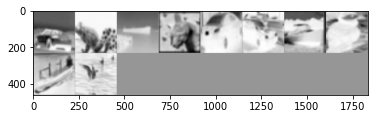

In [18]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('first_visualization_test', img_grid)
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/first_visualization_test/